# Acute Lymphoblastic Leukemia 

**Authors:** Chris John, Erica Robeen, Mauricio Perez, Simran Gill   
**Class:** Datasci 207 - Machine Learning

Leukemia is a type of cancer that affects the blood and bone marrow. This causes the body to producee too much adnormal white blood cells. These cells cannot fight infections and prevent bone marrow from poducing healthy red blood cells and platelets. 

Acute lymphoblastic leukemia is one of the most common type of childhood cancers, totaling up to 25% of pediatric cancers. Identifying leukemic cells from normal cells nuder the microscope can be challenging becuase of the morphological similarities.


**Task:** Using image classification model, identify normal cells from cancer cells. 

**Data Source:** https://www.kaggle.com/datasets/andrewmvd/leukemia-classification

#### ``Objectives``
1. Implement a Convolutional Nural Network (CNN) model to detect leukemic cells from microscopic cell images.
2. Improve generalization performance and reduce overfitting using image transformation and data augmentation techniques.

#### ``Motivation``
Leukemia is a type of cancer that affects the blood and bone marrow, often characterized by abnormal white blood cell production. Early and accurate detection of leukemia through microscopic examination of blood samples is critical for timely treatment and improved patient outcomes. Automating this process with machine learning models can enhance diagnostic efficiency and accessibility, benefiting patients and healthcare systems.

---
### Step 1: Import libraries

In [1]:
import numpy as np
import pandas as pd
import random

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D

# sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Undersampling 
from imblearn.under_sampling import RandomUnderSampler

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Set random seed for reproducibility
random.seed(2)
%matplotlib inline

import os
import zipfile

TRAIN_DATA_PATH = "./C-NMC_Leukemia/training_data"
VAL_DATA_PATH = "./C-NMC_Leukemia/validation_data"


---
### Step 2: Downloading Data
* Combining training and validation set because kaggle does not provide the labels for the test set. 
* After combining, will split the data into train, test, and validation

In [2]:
# # Downloading Data
# '''
# archive = zipfile.ZipFile('archive.zip', 'r')

# # training 
# for file in archive.namelist():
#     if file.startswith('C-NMC_Leukemia/training_data/'):
#         archive.extract(file, './')
# # validation
# for file in archive.namelist():
#     if file.startswith('C-NMC_Leukemia/validation_data'):
#         archive.extract(file, './')
# '''


In [3]:
def load_data(path_to_data,data_type, target_size=(128, 128) ):
    '''Load 2D images and their corresponding labels
    Parameters:
    path_to_data (str): This is the path to data
    data_type (str): This tells us the type of dataset in path_to_data
    target_size (int,int): target size of images

    Returns:
    images (np.ndarray): A numpy array of shape (N, 224, 224, 3)
    labels (np.ndarray): A numpy array of shape (N)
    
    '''
    # also resizing images to help with reducing computational load
    # without resizing, takes up too much memory
    images = []
    labels = []

    # For training data
    if data_type == 'train':
        #Gets each fold in the directory of training_data
        for fold in os.listdir(path_to_data):
            #Gets the fold paths where images are contained
            fold_path = os.path.join(path_to_data, fold)
            # Skip if it's not a folder (specifically for .DS_Store which is throwing errors)
            if os.path.isdir(fold_path):  
                #gets teh label in the fold directory (hem or all)
                for label in os.listdir(fold_path):
                    #gets the directory where the images are in each folder
                    label_path = os.path.join(fold_path, label)
                    # Skip non-directories (like .DS_Store)
                    if os.path.isdir(label_path):
                        #gets the image name in the hem or all directories
                        for image_name in os.listdir(label_path):
                            #gets the path for each image
                            image_path = os.path.join(label_path, image_name)

                            # Load image and resize to 128x128 pixels as default (or the given params)
                            img = load_img(image_path, target_size=target_size)

                            images.append(img)

                            # Creates a binary label (1 for 'all' (with Leukemia), 0 for others (healthy))
                            label_value = 1 if label == 'all' else 0
                            labels.append(label_value)

    # For validation data
    elif data_type == 'val':
        #determines the path for the images in validation folder
        val_images_path = os.path.join(path_to_data, 'C-NMC_test_prelim_phase_data')
        #determines the path for the csv file with the labels
        label_file = os.path.join(path_to_data, 'C-NMC_test_prelim_phase_data_labels.csv')
        # Ensure the images folder and CSV file exist
        if os.path.isdir(val_images_path) and os.path.exists(label_file):
            # Read the CSV file for labels
            df = pd.read_csv(label_file)

            # Get the filenames and labels from the CSV
            image_names = df['new_names'].tolist()  # Filenames
            label_values = df['labels'].tolist()  # Labels

            #goes through the image_name and label_value combination for each
            #row in the csv file to get image name and label for each image.
            for image_name, label_value in zip(image_names, label_values):
                image_path = os.path.join(val_images_path, image_name)

                # Check if the image exists in the folder
                if os.path.exists(image_path):
                    # Load image
                    img = load_img(image_path, target_size=target_size)
                    
                    images.append(img)
                    labels.append(label_value)

        else:
            print(f"Validation images folder or CSV file not found. Make sure they are in {path_to_data}")

    # Convert lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)

    return images, labels

In [4]:
# Leukemia Data
images1, labels1 = load_data(TRAIN_DATA_PATH, "train")
images2, labels2 = load_data(VAL_DATA_PATH, "val")

images = np.concatenate((images1,images2), axis = 0)
labels = np.concatenate((labels1,labels2), axis = 0)

# --- Summary of Dataset ---
print(f"Full Dataset: {images.shape}, Labels: {labels.shape}")


Full Dataset: (12528, 128, 128, 3), Labels: (12528,)


Cancer (1) count: 8491
Healthy (0) count: 4037


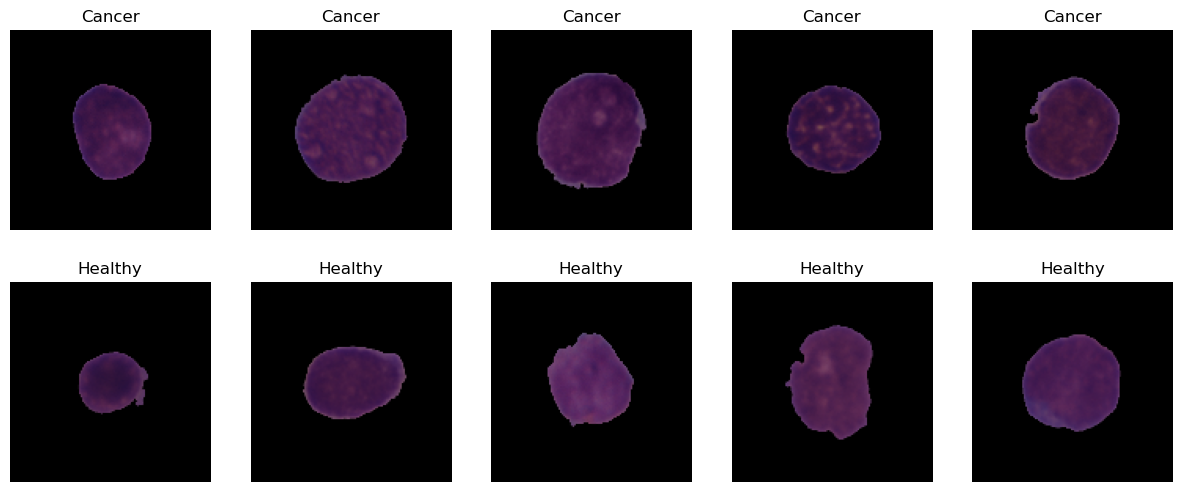

In [5]:
#checking labels and printing the first 5 images of each label

#counts all labels that are 1 (cancerous cells)
cancer_count = np.sum(labels == 1)
#counts all labels that are 0 (healthy cells)
healthy_count = np.sum(labels == 0)

print(f"Cancer (1) count: {cancer_count}")
print(f"Healthy (0) count: {healthy_count}")

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Display last 5 'Cancer' images (label = 1)
cancer_images = images[labels == 1][-5:]
for i, img in enumerate(cancer_images):
    axes[0, i].imshow(img)
    axes[0, i].axis('off')
    axes[0, i].set_title(f"Cancer")

# Display last 5 'Healthy' images (label = 0)
healthy_images = images[labels == 0][-5:]
for i, img in enumerate(healthy_images):
    axes[1, i].imshow(img)
    axes[1, i].axis('off')
    axes[1, i].set_title(f"Healthy")

plt.show()


--- 
### Step 3: Exploratory Data Analysis (EDA)
Plot a histogram to visualize the distribution of the two classes in the leukemia dataset: 'Healthy (hem)' and 'Cancer (all)'. The bar plot displays the total number of samples for each class across the combined training and validation datasets.

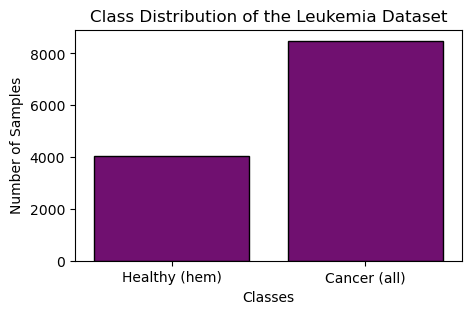

In [6]:
class_counts = np.bincount(labels)
class_names = ['Healthy (hem)', 'Cancer (all)']

# Plot the histogram
plt.figure(figsize=(5, 3))  # Define the figure size only once
sns.barplot(x=class_names, y=class_counts, color = 'purple', edgecolor = 'black')
plt.title('Class Distribution of the Leukemia Dataset')
plt.ylabel('Number of Samples')
plt.xlabel('Classes')
plt.show()

**Comment on class balance:** 
The classes are not too balanced with roughly 2x more cancer (all) samples compared to healthy (hem). It's not realistic that it would reflect the population as a whole, although could reflect the population sent for testing.

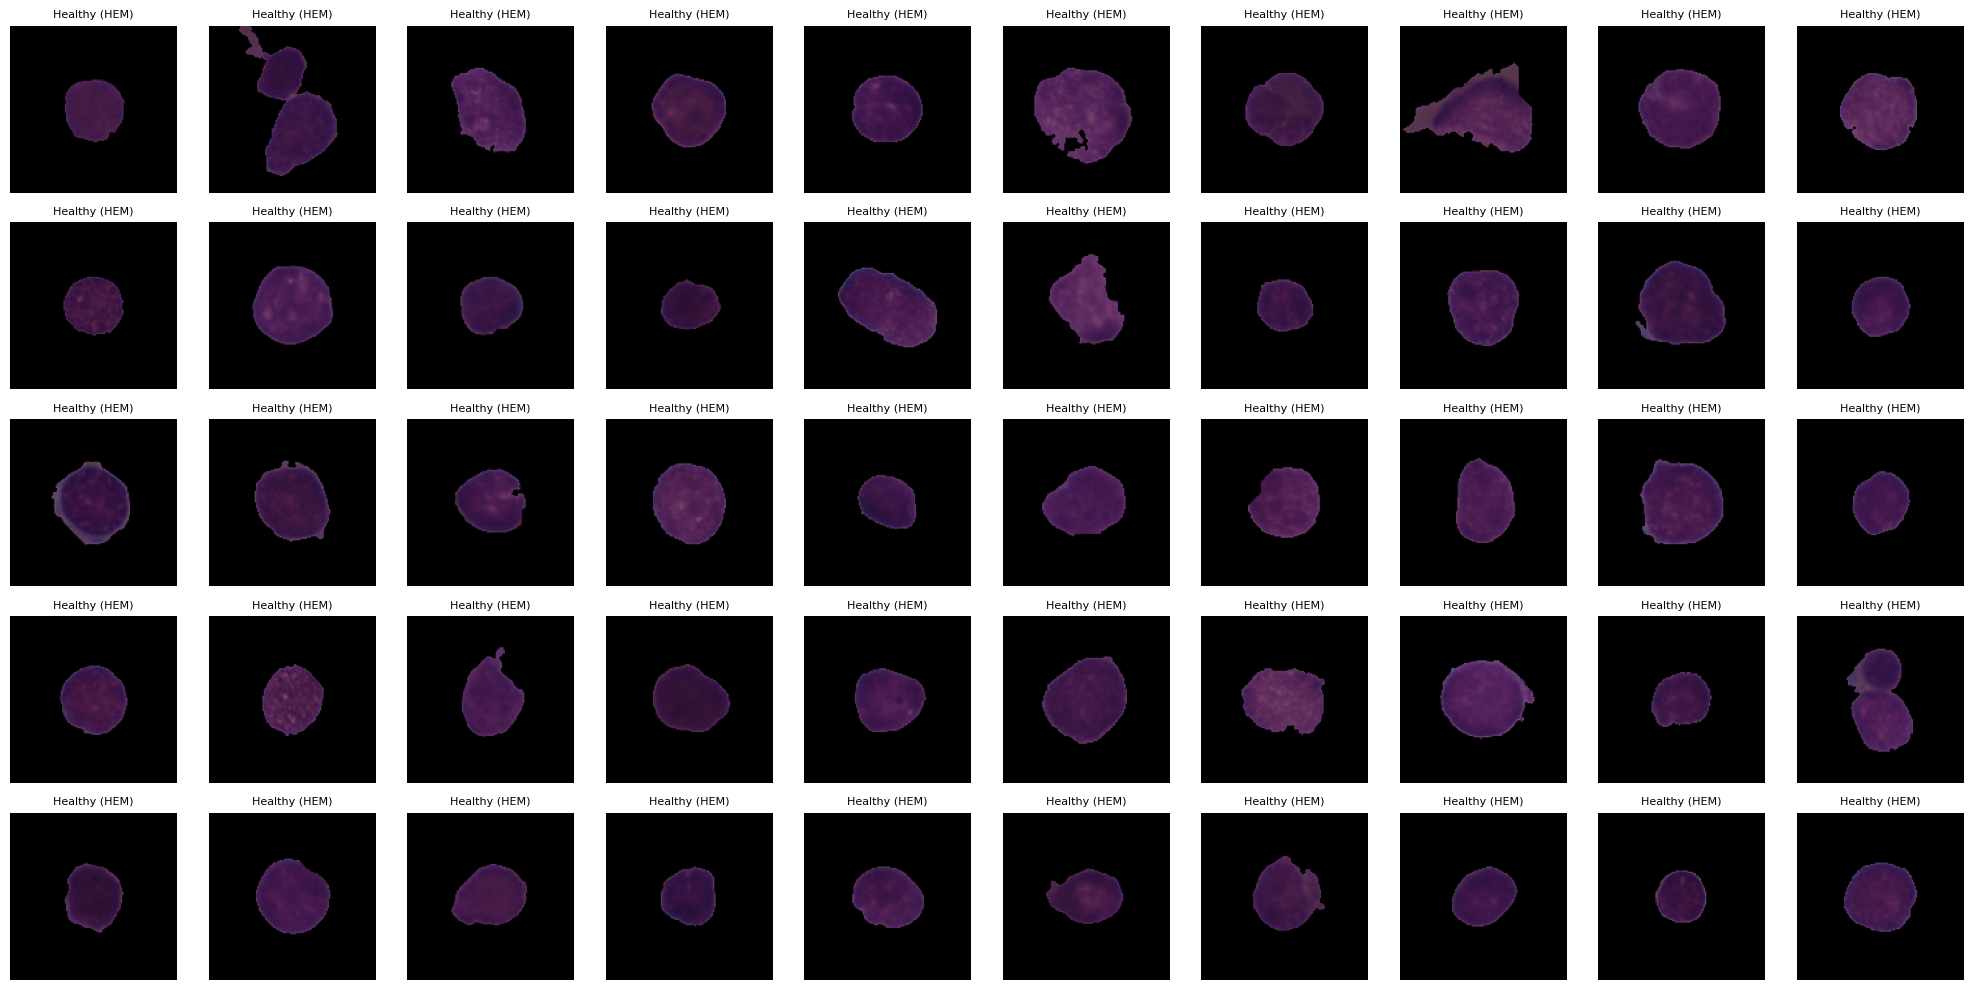

In [7]:
# --- Printing 50 images from the data.---

#using an LLM to assist with coding

# Number of images to display
num_images = 50

# Create a figure to display the images
plt.figure(figsize=(20, 10)) 

for i in range(num_images):
    image = images[i]
    label = 'Cancer (ALL)' if labels[i] == 1 else 'Healthy (HEM)'
    
    # Add a subplot in a 5x10 grid
    plt.subplot(5, 10, i+1)  # 5 rows, 10 columns
    plt.imshow(image)
    plt.title(label, fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

**Comment on the size, focus/orientation of the 50 images:**
* Size: the images all seem to be the same pixels
* Focus: The images have clear cell boundaries and good focus with some boundary abnormalities visible.  The orientation is difficult to assess, but the results still may be better with data augmentation to help.

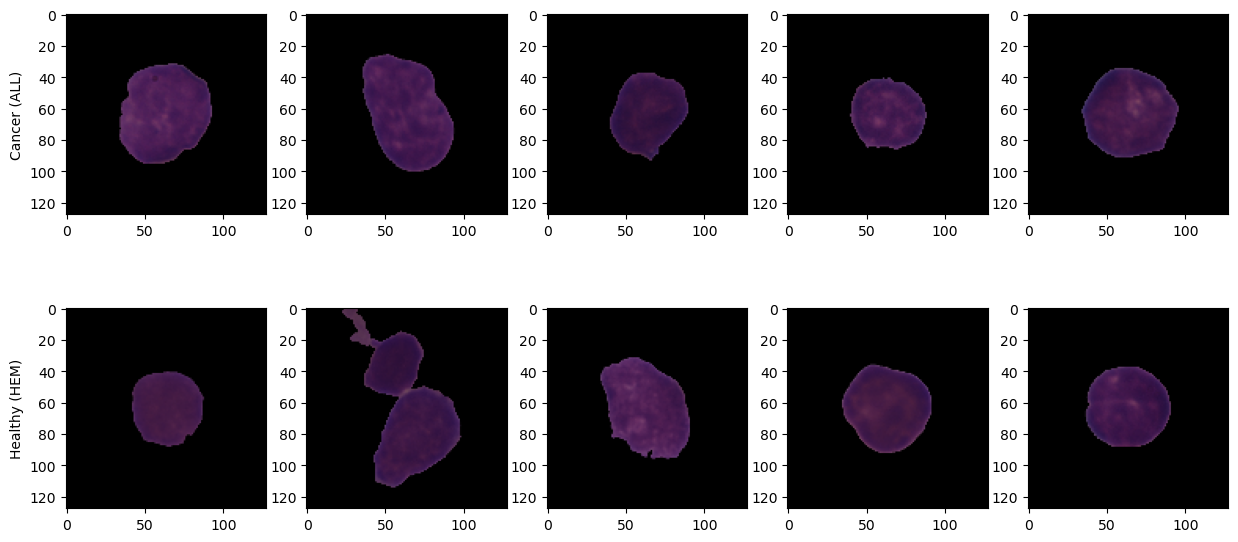

In [8]:
#---First 5 images for each class---

label_names = [1, 0]
class_leukemia = {i: [] for i in label_names}
for  index, value in enumerate(labels):
    if len(class_leukemia[value]) < 5:
        class_leukemia[value].append(images[index])
    if all(len(images) == 5 for images in class_leukemia.values()):
        break

# ploting 5 images per class
fig, axes = plt.subplots(2,5, figsize = (15, 7))
for label_index in range(len(label_names)):
    for image_index in range(5):
        ax = axes[label_index, image_index]
        ax.imshow(class_leukemia[label_names[label_index]][image_index])
        if image_index == 0:
            if label_names[label_index] == 1:
                ax.set_ylabel("Cancer (ALL)")
            else:
                ax.set_ylabel("Healthy (HEM)")

**Characteristic of Classes:** Considerig the small sample dislayed,Cancer(ALL) class cells come in various shapes with some having a small white dot on the cell. When it comes to the Healthy (HEM) class, most are close to being a circle with no white dot.  

---
### Step 4: Data Preprocessing 
Rescaling images by dividing each pixal by 255.0. This helps with scaling the values to a range of 0 to 1, wich makes the data more suitable for ML models especially when it comes to CNN.

From the histogram above, we can see there is an imbalance in labels. There are more cancer cells than healthy cells. '
https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/
* By undersampling we are can help prevent model bias towards majority class. This helps with imporving learning for minority class.




In [9]:
# Rescale images by dividing each pixel by 255.0 to normalize to the range [0, 1]
images_scaled = images.astype('float32') / 255.0

# Confirm that the images have been scaled (check range)
print(f"Images scaled to the range: [{images_scaled.min()}, {images_scaled.max()}]")

# Check the shape of images to ensure everything is in order
print("Scaled Images shape:", images_scaled.shape)

#checking first image array. 
print("First Image: ", images_scaled[0])

Images scaled to the range: [0.0, 0.8509804010391235]
Scaled Images shape: (12528, 128, 128, 3)
First Image:  [[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]


In [12]:
# Check the range of pixel values in the original images (before scaling)
print(f"Original Images range: [{images.min()}, {images.max()}]")


Original Images range: [0, 217]


In [13]:
# # --Undersampling majority and Normalizing--

# # rescaling data by dividing each pixal by 255.0
# images = images.astype('float32') / 255.0
# # reshaping numpy array
# num_samples, height, width, channels = images.shape
# images_reshaped = images.reshape(num_samples, -1)
# # applying undersampling
# undersample = RandomUnderSampler(sampling_strategy='majority')
# images_mini, labels_mini = undersample.fit_resample(images_reshaped, labels)
# # reshaping images back to 3D
# num_samples_mini = images_mini.shape[0]
# images_mini_reshaped = images_mini.reshape(num_samples_mini, height, width, channels)

# # After undersampling bar graph
# class_counts = np.bincount(labels_mini)
# class_names = ['Healthy (hem)', 'Cancer (all)']
# plt.figure(figsize=(5, 3)) 
# sns.barplot(x=class_names, y=class_counts, color = 'purple', edgecolor = 'black')
# plt.title("Leukemia Classification After Undersampling")
# plt.ylabel('Number of Samples')
# plt.xlabel('Classes')
# plt.show()

### Split Data into Train, Test, Validation

Prepare training, validation, and test datasets with lazy loading and on-the-fly transformations for the leukemia classification task. The goal of the function is to ensure the model has balanced data for train, validation, and test, while leveraging augmentation to improve generalization.  Lazy loading is utilized to help process the large dataset by processing on demand.

Data Splitting:
Shuffle images and labels before splitting to ensure randomness.
Divide the dataset into training, validation, and test sets using a (0.6, 0.2, 0.2) split ratio.

Lazy Loading:
Convert data into TensorFlow datasets (tf.data.Dataset) for efficient processing.
Batch and prefetch the data to optimize pipeline performance during model training.

Data Augmentation:
Augment the training data with horizontal flips using TensorFlow's tf.image module to improve generalization and prevent overfitting.
Note: Augmentation is applied only to the training dataset.

Data Preparation:
Rescale pixel values in all datasets to the range [0, 1] by dividing by 255.0.
Use batching and prefetching to speed up data loading and ensure efficient utilization of GPU/CPU during training.

In [14]:
'''def splitting_data(images, labels, splits):
    """ Split data into train, validation, and test set 
    Params:
    -------
    images (np.ndarray): Images of shape ...
    labels (np.ndarray): Labels of shape(N, )
    """
    np.random.seed(1234)

    # shuffle data
    indices = np.arange(len(labels))
    np.random.shuffle(indices)
    images = images[indices]
    labels = labels[indices]

    # create data splits (training, val, test)
    X_train, X_temp, y_train, Y_temp = train_test_split(images, labels, test_size = (1 - splits[0]), random_state = 1234)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, Y_temp, test_size=splits[2]/(splits[1]+splits[2]), random_state=1234)

    return X_train, y_train, X_val, y_val, X_test, y_test'''

'def splitting_data(images, labels, splits):\n    """ Split data into train, validation, and test set \n    Params:\n    -------\n    images (np.ndarray): Images of shape ...\n    labels (np.ndarray): Labels of shape(N, )\n    """\n    np.random.seed(1234)\n\n    # shuffle data\n    indices = np.arange(len(labels))\n    np.random.shuffle(indices)\n    images = images[indices]\n    labels = labels[indices]\n\n    # create data splits (training, val, test)\n    X_train, X_temp, y_train, Y_temp = train_test_split(images, labels, test_size = (1 - splits[0]), random_state = 1234)\n    X_val, X_test, y_val, y_test = train_test_split(X_temp, Y_temp, test_size=splits[2]/(splits[1]+splits[2]), random_state=1234)\n\n    return X_train, y_train, X_val, y_val, X_test, y_test'

In [15]:
# def splitting_data(images, labels, splits = (0.6,0.2,0.2), batch_size = 32):
#     """
#     Split data into train, validation, and test sets; apply on-the-fly transformations and lazy loading.

#     Params:
#     -------
#     images (np.ndarray): Images of shape (N, H, W, C).
#     labels (np.ndarray): Labels of shape (N,).
#     splits (tuple): Proportions for train, validation, and test sets (must sum to 1).
#     batch_size (int): Batch size for data generators.

#     Returns:
#     --------
#     train_dataset (tf.data.Dataset): Dataset for training (with augmentation).
#     val_dataset (tf.data.Dataset): Dataset for validation.
#     test_dataset (tf.data.Dataset): Dataset for testing.
#     """

#     # Shuffle data
#     indices = np.arange(len(labels))
#     np.random.shuffle(indices)
#     images = images[indices]
#     labels = labels[indices]

#     # Split data into train, validation, and test sets
#     X_train, X_temp, y_train, Y_temp = train_test_split(images, labels, test_size=(1 - splits[0]), random_state=1234)
#     X_val, X_test, y_val, y_test = train_test_split(X_temp, Y_temp, test_size=splits[2]/(splits[1] + splits[2]), random_state=1234)

#     # Image augmentation (random flip) on training data
#     X_train_augm = np.array([tf.image.random_flip_left_right(img).numpy() for img in X_train])
#     X_train = np.concatenate([X_train, X_train_augm])
#     # Concatenate y_train (note the label is preserved)
#     y_train_augm = y_train
#     y_train = tf.concat([y_train, y_train_augm], axis=0)
    
#     # Create datasets
#     train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
#     val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
#     test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

#     # Shuffle and batch datasets
#     train_dataset = train_dataset.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
#     val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
#     test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

#     return train_dataset, val_dataset, test_dataset

In [16]:
# split = (0.6, 0.2, 0.2)
# batch_size = 32
# train_dataset, val_dataset, test_dataset = splitting_data(
#     images_mini_reshaped,
#     labels_mini,
#     splits=split,
#     batch_size=batch_size
# )

In [17]:
from sklearn.model_selection import train_test_split

# Split into train and temp (80% train, 20% temp for validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    #X and Y data
    images, labels, 
    # 40% will be split into validation and test
    test_size=0.4,
    # Ensure class balance is maintained in the splits
    stratify=labels,
    #Keeping a random state constant for replicabilty.
    random_state=42
)

# Now split the temp data into validation and test (50% of the temp data for each, so 20% for each split)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, 
    # 50% of temp data goes to validation, 50% to test
    test_size=0.5,
    # Ensure class balance is maintained in the splits  
    stratify=y_temp,
    #Keeping a random state constant for replicabilty.
    random_state=42
)


# Verify the splits and class distribution
print(f"Training set: {len(y_train)} samples, {np.bincount(y_train)} class distribution")
print(f"Validation set: {len(y_val)} samples, {np.bincount(y_val)} class distribution")
print(f"Testing set: {len(y_test)} samples, {np.bincount(y_test)} class distribution")


Training set: 7516 samples, [2422 5094] class distribution
Validation set: 2506 samples, [ 807 1699] class distribution
Testing set: 2506 samples, [ 808 1698] class distribution


In [18]:
def augment_data(X_train, y_train, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2,
                 shear_range=0.2, horizontal_flip=True, vertical_flip=True,
                 brightness_range=[0.8, 1.2], zoom_range = 0.2, contrast_range=[0.7, 1.3], fill_mode='nearest'):
    """
    Apply augmentations (flip, rotation, shift, shear, zoom, brightness, contrast) to the training images
    
    Params:
    -------
    X_train (np.ndarray): Training images to be augmented
    y_train (np.ndarray): Train labels corresponding to images
    rotation_range (int): Maximum rotation angle in degrees.
    width_shift_range (float): Fraction of total width to shift.
    height_shift_range (float): Fraction of total height to shift.
    shear_range (float): Fraction of shear transformation.
    zoom_range (float): Fraction of zoom-in/zoom-out range.
    horizontal_flip (bool): Whether to flip images horizontally.
    vertical_flip (bool): Whether to flip images vertically.
    brightness_range (list): Random brightness adjustment range [min, max].
    contrast_range (list): Random contrast adjustment range [min, max].
    fill_mode (str): Mode for filling missing pixels ('nearest', 'constant', 'reflect', 'wrap').

    Returns:
    --------
    X_train_augmented (np.ndarray): Augmented training images of shape (N_train * 2, H, W, C)
    y_train_augmented (np.ndarray): Augmented labels of shape (N_train * 2,)
    """
    
    augmented_images = []

    for img in X_train:
        # Random Horizontal Flip
        if horizontal_flip:
            img = tf.image.random_flip_left_right(img)
        
        # Random Vertical Flip
        if vertical_flip:
            img = tf.image.random_flip_up_down(img)
        
        # Random Rotation within the specified range
        if rotation_range > 0:
            img = tf.image.rot90(img) if tf.random.uniform([]) > 0.5 else img
            img = tf.image.rot90(img) if tf.random.uniform([]) > 0.5 else img  # Apply random rotation

        # Random width and height shift
        if width_shift_range > 0 or height_shift_range > 0:
            img = tf.image.random_flip_left_right(img)
            img = tf.image.random_flip_up_down(img)

        # Random Shear Transformation
        if shear_range > 0:
            img = tf.image.random_contrast(img, 0.8, 1.2)

        # Random Zoom (zoom-in or zoom-out)
        if zoom_range > 0:
            img = tf.image.resize(img, size=(int(img.shape[0] * zoom_range), int(img.shape[1] * zoom_range)))

        # Random Brightness Adjustment
        img = tf.image.random_brightness(img, max_delta=0.2)
        
        # Random Contrast Adjustment
        img = tf.image.random_contrast(img, lower=0.7, upper=1.3)

        # Ensure image size remains the same (250x250)
        img = tf.image.resize(img, [128, 128])  # Ensure image size remains the same (250x250)


        augmented_images.append(img)

    X_train_augmented = tf.stack(augmented_images)


    # Concatenate original images with augmented images (duplicating the dataset)
    X_train_augmented = tf.concat([X_train, X_train_augmented], axis=0)
    y_train_augmented = tf.concat([y_train, y_train], axis=0)  # labels are preserved as is

    # Shuffle the dataset
    shuffled_indices = tf.random.shuffle(tf.range(tf.shape(X_train_augmented)[0], dtype=tf.int32))
    # transform X back to numpy array instead of tensor
    X_train_augmented = tf.gather(X_train_augmented, shuffled_indices).numpy()
    # transform y back to numpy array instead of tensor
    y_train_augmented = tf.gather(y_train_augmented, shuffled_indices).numpy()

    return X_train_augmented, y_train_augmented


In [19]:
# Apply augmentation to the training set
X_train_augmented, y_train_augmented = augment_data(X_train, y_train)

In [21]:
# Before augmenting the data and concatenating
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

# After augmenting the data and concatenating
print("Shape of X_train_augmented:", X_train_augmented.shape)
print("Shape of y_train_augmented:", y_train_augmented.shape)


Shape of X_train: (7516, 128, 128, 3)
Shape of y_train: (7516,)
Shape of X_train_augmented: (15032, 128, 128, 3)
Shape of y_train_augmented: (15032,)


---
### Step 5: Base Model

The objective of this code is to build and train a Convolutional Neural Network (CNN) model to classify leukemia cell images into two categories: healthy (hem) and cancerous (all). This binary classification can assist in automating the process of distinguishing cancerous cells from healthy ones, thereby supporting early detection and diagnosis of leukemia.

The code implements a CNN classifier as follows:

1. The model is implemented using TensorFlow's Keras API.
2. The model accepts input images of size 224 x 224 x 3 (RGB format, three color channels).
3. The first layer is a convolutional layer with the following specifications::
    - filters = 12
    - kernel_size = (4 x 4)
    - strides = (1, 1)
    - padding = 'same'
    - data_format = 'channels_last'
    - name = 'conv_1'
    - activation = 'relu'
4. Max-pooling Layer: The convolutional layer is followed by a max-pooling layer with pool_size = (2,2). This reduces the spatial dimensions of the feature maps, thereby decreasing computational complexity while retaining key features.
5. Dropout Layer: The max-pooling layer is followed by a dropout layer with rate = 0.3 to prevent overfitting by randomly deactivating 30% of neurons during training. 
6. Flattening Layer: The feature maps are flattened into a 1D array to prepare the data for the fully connected layer.
7. Classification Layer: The final layer is a dense layer with one neuron and a sigmoid activation function which outputs the probability of the image belonging to the cancerous category.
8. Model Compilation: The model is compiled as follows:
    - Optimizer: Adam optimizer with a learning rate of 0.1
    - Loss function: Binary crossentropy for binary classification
    - Metrc: Accuracy
    - Training: The model is trained for up to 20 epochs using the train_dataset and validated on the val_dataset.  An eary stopping mechanism is utilized to halt training when the validation loss stops improving for 5 consecutive epochs.
9. A plot is generated of training and validation loss over epochs to visualize the learning process.
10. Evaluation: The model's accuracy and loss are evaluated on both the training and validation data sets providing important insight into the model's performance.  

In [27]:
# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    verbose=1,
    mode='min', 
    restore_best_weights=True
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 128, 128, 12)   │           588 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64, 64, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │        49,153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,741 (194.30 KB)

 Trainable params: 49,741 (194.30 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.6111 - loss: 1211.9280 - val_accuracy: 0.6393 - val_loss: 0.9446
Epoch 2/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.6417 - loss: 2113.6763 - val_accuracy: 0.6776 - val_loss: 0.6345
Epoch 3/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.6661 - loss: 790.8070 - val_accuracy: 0.6684 - val_loss: 0.8716
Epoch 4/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.6673 - loss: 1222.2579 - val_accuracy: 0.6768 - val_loss: 0.6787
Epoch 5/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.6495 - loss: 22.3966 - val_accuracy: 0.6780 - val_loss: 0.6292
Epoch 6/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.6740 - loss: 66.4522 - val_accuracy: 0.6700 - val_loss: 2.1254
Epoch 7/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.6632 - loss: 209.6255 - val_accuracy: 0.6784 - val_loss: 0.6869
Epoch 8/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.6752 - 

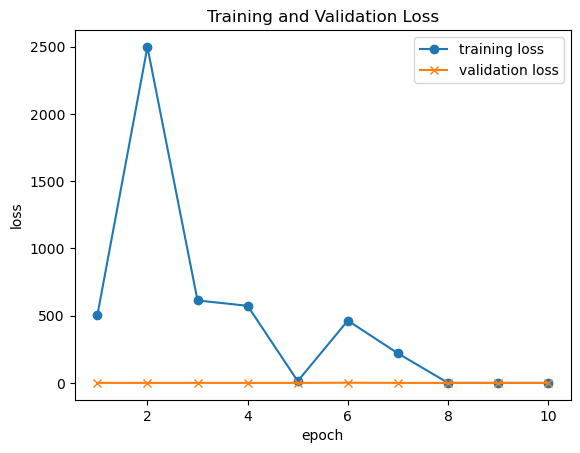

Training Accuracy: 0.6777
Validation Accuracy: 0.6780


In [ ]:
# Set random seeds for reproducibility
tf.random.set_seed(1234)
np.random.seed(1234)

# Initialize the model
model_tf = tf.keras.Sequential()

# Add convolutional layer
model_tf.add(tf.keras.layers.Conv2D(
    filters=12,
    kernel_size=(4, 4),
    strides=(1, 1),
    padding='same',
    data_format='channels_last',
    activation='relu',
    name='conv_1'
))

# Add max pooling layer
model_tf.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Add dropout layer
model_tf.add(tf.keras.layers.Dropout(rate=0.3))

# Add flattening layer
model_tf.add(tf.keras.layers.Flatten())

# Add classification layer
model_tf.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Build and compile the model
model_tf.build(input_shape=(None, 128, 128, 3))
model_tf.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
                 loss=tf.keras.losses.BinaryCrossentropy(),
                 metrics=['accuracy'])

# Print the model summary
model_tf.summary()

# Train the model
history = model_tf.fit(
    x=X_train_augmented,
    y=y_train_augmented,
    validation_data=(X_val,y_val), 
    epochs=20,
    callbacks=[early_stopping]
)

# Plot loss curves
x_arr = np.arange(len(history.history['loss'])) + 1
plt.plot(x_arr ,history.history['loss'], '-o', label='training loss')
plt.plot(x_arr ,history.history['val_loss'], '-x', label='validation loss')
plt.title("Training and Validation Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

# Evaluate the model on training and validation data
train_loss, train_accuracy = model_tf.evaluate(x=X_train_augmented, y=y_train_augmented, verbose=0)
val_loss, val_accuracy = model_tf.evaluate(x=X_val, y=y_val, verbose=0)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")



How many parameters does model_tf have? 49,741 parameters

Comment on model_tf accuracy on training vs. validation data: The training accuracy is 0.4922 verses the validation accuracy of 0.5146. This is close to just random guessing and not great performance. The values are similar vetween accuracy and validation, which could suggest underfitting.

Build and train a Convolutional Neural Network (CNN) to classify leukemia images into two categories: 'Healthy (hem)' and 'Cancer (all)'. This binary classification task aims to identify cancerous samples for further medical evaluation.

---
### Step 6: Modifying Model

Here we are attempting to improve the model from the base model by:
* Applying additional Data augmentation layers 
* Three Convolutional blocks
* Dense hidden layer 

In [ ]:
# # Initialize the fine-tuned model
# model_fine_tuned = tf.keras.Sequential()

# # Data augmentation layers
# model_fine_tuned.add(tf.keras.layers.RandomRotation(factor=0.1, input_shape=(128, 128, 3)))
# model_fine_tuned.add(tf.keras.layers.RandomZoom(height_factor=0.1, width_factor=0.1))
# model_fine_tuned.add(tf.keras.layers.RandomBrightness(factor=0.2))
# model_fine_tuned.add(tf.keras.layers.RandomFlip(mode="horizontal"))

# # Define class weights to address class imbalance
# class_weight = {0: 1.0, 1: 1.2}

# # First convolutional block
# model_fine_tuned.add(tf.keras.layers.Conv2D(
#     filters=32,  # Increased filters
#     kernel_size=(3, 3),
#     strides=(1, 1),
#     padding='same',
#     activation='relu',
#     name='conv_1'
# ))
# model_fine_tuned.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# # Second convolutional block
# model_fine_tuned.add(tf.keras.layers.Conv2D(
#     filters=64,  # Increased filters
#     kernel_size=(3, 3),
#     strides=(1, 1),
#     padding='same',
#     activation='relu',
#     name='conv_2'
# ))
# model_fine_tuned.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# # Third convolutional block
# model_fine_tuned.add(tf.keras.layers.Conv2D(
#     filters=128,  # Further increased filters
#     kernel_size=(3, 3),
#     strides=(1, 1),
#     padding='same',
#     activation='relu',
#     name='conv_3'
# ))
# model_fine_tuned.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# # Dropout layer to prevent overfitting
# model_fine_tuned.add(tf.keras.layers.Dropout(rate=0.5))

# # Flatten layer
# model_fine_tuned.add(tf.keras.layers.Flatten())

# # Dense hidden layer
# model_fine_tuned.add(tf.keras.layers.Dense(128, activation='relu', name='dense_hidden'))
# model_fine_tuned.add(tf.keras.layers.Dropout(rate=0.4))  # Increased dropout

# # Classification layer
# model_fine_tuned.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# # Build and compile the model with an adjusted learning rate
# model_fine_tuned.build(input_shape=(None, 128, 128, 3))
# model_fine_tuned.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Higher learning rate
#                  loss=tf.keras.losses.BinaryCrossentropy(),
#                  metrics=['accuracy'])

# # Print the model summary
# model_fine_tuned.summary()

# # Train the model with class weights
# history = model_fine_tuned.fit(
#     train_dataset,  # Lazy-loaded dataset
#     validation_data=val_dataset,  # Lazy-loaded dataset
#     epochs=25,
#     class_weight=class_weight,  # Address class imbalance
#     callbacks=[early_stopping]
# )

# # Plot loss curves
# x_arr = np.arange(len(history.history['loss'])) + 1
# plt.plot(x_arr ,history.history['loss'], '-o', label='training loss')
# plt.plot(x_arr ,history.history['val_loss'], '-x', label='validation loss')
# plt.title("Training and Validation Loss")
# plt.xlabel('epoch')
# plt.ylabel('loss')
# plt.legend()
# plt.show()

# # Evaluate the model on training and validation datasets
# train_loss, train_accuracy = model_fine_tuned.evaluate(train_dataset, verbose=0)
# val_loss, val_accuracy = model_fine_tuned.evaluate(val_dataset, verbose=0)

# print(f"Training Accuracy: {train_accuracy:.4f}")
# print(f"Validation Accuracy: {val_accuracy:.4f}")

/Users/mauricioperez/anaconda3/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_rotation                 │ (None, 128, 128, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_brightness               │ (None, 128, 128, 3)    │             0 │
│ (RandomBrightness)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_hidden (Dense)            │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,287,809 (16.36 MB)

 Trainable params: 4,287,809 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
470/470 ━━━━━━━━━━━━━━━━━━━━ 54s 113ms/step - accuracy: 0.7184 - loss: 1.2928 - val_accuracy: 0.7869 - val_loss: 0.5129
Epoch 2/25
470/470 ━━━━━━━━━━━━━━━━━━━━ 53s 113ms/step - accuracy: 0.7705 - loss: 0.5645 - val_accuracy: 0.7921 - val_loss: 0.4887
Epoch 3/25
470/470 ━━━━━━━━━━━━━━━━━━━━ 53s 113ms/step - accuracy: 0.7770 - loss: 0.5449 - val_accuracy: 0.7953 - val_loss: 0.4586
Epoch 4/25
470/470 ━━━━━━━━━━━━━━━━━━━━ 53s 113ms/step - accuracy: 0.7858 - loss: 0.5352 - val_accuracy: 0.7985 - val_loss: 0.4544
Epoch 5/25
470/470 ━━━━━━━━━━━━━━━━━━━━ 54s 114ms/step - accuracy: 0.7806 - loss: 0.5373 - val_accuracy: 0.7969 - val_loss: 0.4503
Epoch 6/25
470/470 ━━━━━━━━━━━━━━━━━━━━ 54s 114ms/step - accuracy: 0.7856 - loss: 0.5304 - val_accuracy: 0.8049 - val_loss: 0.4394
Epoch 7/25
470/470 ━━━━━━━━━━━━━━━━━━━━ 56s 120ms/step - accuracy: 0.7879 - loss: 0.5253 - val_accuracy: 0.8093 - val_loss: 0.4583
Epoch 8/25
470/470 ━━━━━━━━━━━━━━━━━━━━ 55s 116ms/step - accuracy: 0.7901 - loss: 0

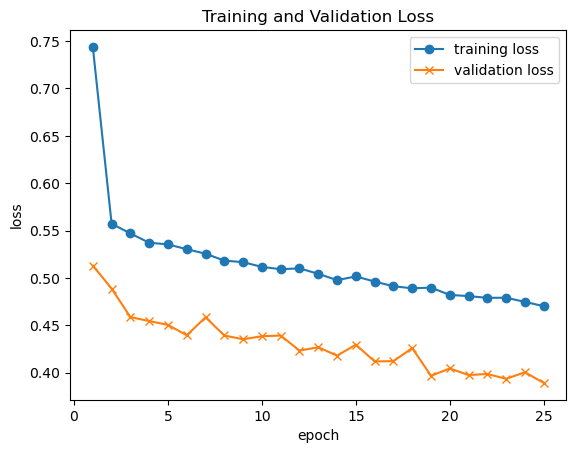

Training Accuracy: 0.8250
Validation Accuracy: 0.8388


In [ ]:
# Set random seeds for reproducibility
tf.random.set_seed(1234)
np.random.seed(1234)

# Initialize the fine-tuned model
model_fine_tuned = tf.keras.Sequential()

# Data augmentation layers (same augmentation as previous model)
model_fine_tuned.add(tf.keras.layers.RandomRotation(factor=0.1, input_shape=(128, 128, 3)))
model_fine_tuned.add(tf.keras.layers.RandomZoom(height_factor=0.1, width_factor=0.1))
model_fine_tuned.add(tf.keras.layers.RandomBrightness(factor=0.2))
model_fine_tuned.add(tf.keras.layers.RandomFlip(mode="horizontal"))

# First convolutional block
model_fine_tuned.add(tf.keras.layers.Conv2D(
    filters=32,  # Increased filters
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='same',
    activation='relu',
    name='conv_1'
))
model_fine_tuned.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Second convolutional block
model_fine_tuned.add(tf.keras.layers.Conv2D(
    filters=64,  # Increased filters
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='same',
    activation='relu',
    name='conv_2'
))
model_fine_tuned.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Third convolutional block
model_fine_tuned.add(tf.keras.layers.Conv2D(
    filters=128,  # Further increased filters
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='same',
    activation='relu',
    name='conv_3'
))
model_fine_tuned.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Dropout layer to prevent overfitting
model_fine_tuned.add(tf.keras.layers.Dropout(rate=0.5))

# Flatten layer
model_fine_tuned.add(tf.keras.layers.Flatten())

# Dense hidden layer
model_fine_tuned.add(tf.keras.layers.Dense(128, activation='relu', name='dense_hidden'))
model_fine_tuned.add(tf.keras.layers.Dropout(rate=0.4))  # Increased dropout

# Classification layer
model_fine_tuned.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Build and compile the model with an adjusted learning rate
model_fine_tuned.build(input_shape=(None, 128, 128, 3))
model_fine_tuned.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Lower learning rate for fine-tuning
                         loss=tf.keras.losses.BinaryCrossentropy(),
                         metrics=['accuracy'])

# Print the model summary
model_fine_tuned.summary()

# Define class weights to address class imbalance
class_weight = {0: 3.1, 1: 1.5}

# Train the model with data augmentation, class weights, and early stopping
history = model_fine_tuned.fit(
    X_train_augmented,  # Input data (numpy array)
    y_train_augmented,  # Target labels (numpy array)
    validation_data=(X_val, y_val),  # Validation data (numpy array)
    epochs=25,
    class_weight=class_weight,  # Address class imbalance
    callbacks=[early_stopping]
)

# Plot loss curves
x_arr = np.arange(len(history.history['loss'])) + 1
plt.plot(x_arr ,history.history['loss'], '-o', label='training loss')
plt.plot(x_arr ,history.history['val_loss'], '-x', label='validation loss')
plt.title("Training and Validation Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

# Evaluate the model on training and validation datasets
train_loss, train_accuracy = model_fine_tuned.evaluate(X_train_augmented, y_train_augmented, verbose=0)
val_loss, val_accuracy = model_fine_tuned.evaluate(X_val, y_val, verbose=0)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_rotation_1               │ (None, 128, 128, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_1 (RandomZoom)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_brightness_1             │ (None, 128, 128, 3)    │             0 │
│ (RandomBrightness)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_1 (RandomFlip)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_hidden (Dense)            │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,483,265 (32.36 MB)

 Trainable params: 8,482,817 (32.36 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/25
470/470 ━━━━━━━━━━━━━━━━━━━━ 80s 168ms/step - accuracy: 0.6771 - loss: 1.8592 - val_accuracy: 0.7358 - val_loss: 0.5626
Epoch 2/25
470/470 ━━━━━━━━━━━━━━━━━━━━ 79s 168ms/step - accuracy: 0.7496 - loss: 1.1488 - val_accuracy: 0.7853 - val_loss: 0.5238
Epoch 3/25
470/470 ━━━━━━━━━━━━━━━━━━━━ 79s 169ms/step - accuracy: 0.7571 - loss: 1.1187 - val_accuracy: 0.7977 - val_loss: 0.4762
Epoch 4/25
470/470 ━━━━━━━━━━━━━━━━━━━━ 80s 169ms/step - accuracy: 0.7693 - loss: 1.0847 - val_accuracy: 0.7953 - val_loss: 0.5055
Epoch 5/25
470/470 ━━━━━━━━━━━━━━━━━━━━ 79s 168ms/step - accuracy: 0.7648 - loss: 1.0901 - val_accuracy: 0.7945 - val_loss: 0.4898
Epoch 6/25
470/470 ━━━━━━━━━━━━━━━━━━━━ 79s 169ms/step - accuracy: 0.7666 - loss: 1.0777 - val_accuracy: 0.8005 - val_loss: 0.4746
Epoch 7/25
470/470 ━━━━━━━━━━━━━━━━━━━━ 79s 169ms/step - accuracy: 0.7724 - loss: 1.0784 - val_accuracy: 0.8085 - val_loss: 0.4578
Epoch 8/25
470/470 ━━━━━━━━━━━━━━━━━━━━ 107s 228ms/step - accuracy: 0.7677 - loss: 

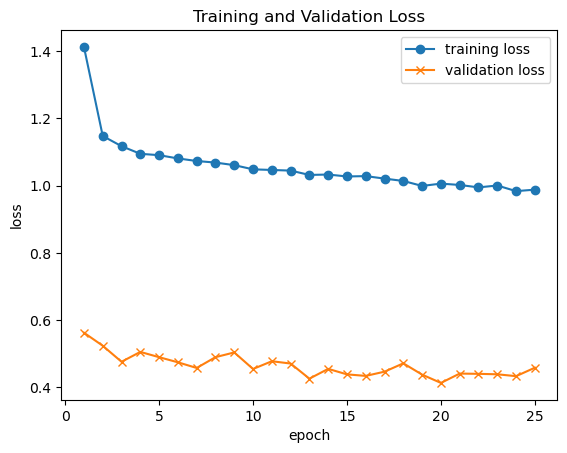

Training Accuracy: 0.7974
Validation Accuracy: 0.8296


In [30]:
# Set random seeds for reproducibility
tf.random.set_seed(1234)
np.random.seed(1234)

# Initialize the fine-tuned model
model_fine_tuned = tf.keras.Sequential()

# Data augmentation layers (included directly in the model)
model_fine_tuned.add(tf.keras.layers.RandomRotation(factor=0.1, input_shape=(128, 128, 3)))
model_fine_tuned.add(tf.keras.layers.RandomZoom(height_factor=0.1, width_factor=0.1))
model_fine_tuned.add(tf.keras.layers.RandomBrightness(factor=0.2))
model_fine_tuned.add(tf.keras.layers.RandomFlip(mode="horizontal"))

# First convolutional block
model_fine_tuned.add(tf.keras.layers.Conv2D(
    filters=32,  # Increased filters
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='same',
    activation='relu',
    name='conv_1'
))
model_fine_tuned.add(tf.keras.layers.BatchNormalization())  # Batch Normalization
model_fine_tuned.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Second convolutional block
model_fine_tuned.add(tf.keras.layers.Conv2D(
    filters=64,  # Increased filters
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='same',
    activation='relu',
    name='conv_2'
))
model_fine_tuned.add(tf.keras.layers.BatchNormalization())  # Batch Normalization
model_fine_tuned.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Third convolutional block
model_fine_tuned.add(tf.keras.layers.Conv2D(
    filters=128,  # Further increased filters
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='same',
    activation='relu',
    name='conv_3'
))
model_fine_tuned.add(tf.keras.layers.BatchNormalization())  # Batch Normalization
model_fine_tuned.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Dropout layer to prevent overfitting
model_fine_tuned.add(tf.keras.layers.Dropout(rate=0.5))

# Flatten layer
model_fine_tuned.add(tf.keras.layers.Flatten())

# Dense hidden layer
model_fine_tuned.add(tf.keras.layers.Dense(256, activation='relu', name='dense_hidden'))  # Increased hidden units
model_fine_tuned.add(tf.keras.layers.Dropout(rate=0.5))  # Increased dropout rate

# Output layer
model_fine_tuned.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Compile the model with a lower learning rate
model_fine_tuned.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                          loss=tf.keras.losses.BinaryCrossentropy(),
                          metrics=['accuracy'])

# Print the model summary
model_fine_tuned.summary()

# Compute class weights based on the training set
class_weight = {0: 3.1, 1: 1.5}  # Adjusted based on inverse frequency

# Define EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,  # Increased patience
    restore_best_weights=True
)

# Train the fine-tuned model with data augmentation, class weights, early stopping
history = model_fine_tuned.fit(
    X_train_augmented,  # Input data (numpy array)
    y_train_augmented,  # Target labels (numpy array)
    validation_data=(X_val, y_val),  # Validation data (numpy array)
    epochs=25,
    class_weight=class_weight,  # Apply class weights to address imbalance
    callbacks=[early_stopping]  # Apply early stopping
)

# Plot loss curves to visualize training and validation loss over epochs
x_arr = np.arange(len(history.history['loss'])) + 1
plt.plot(x_arr, history.history['loss'], '-o', label='training loss')
plt.plot(x_arr, history.history['val_loss'], '-x', label='validation loss')
plt.title("Training and Validation Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

# Evaluate the model on the training and validation sets
train_loss, train_accuracy = model_fine_tuned.evaluate(X_train_augmented, y_train_augmented, verbose=0)
val_loss, val_accuracy = model_fine_tuned.evaluate(X_val, y_val, verbose=0)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 128, 128, 12)   │           588 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 64, 64, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 64, 64, 24)     │         4,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 32, 32, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32, 32, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 24576)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │        24,577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,797 (116.39 KB)

 Trainable params: 29,797 (116.39 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 23s 48ms/step - accuracy: 0.6711 - loss: 266.6292 - val_accuracy: 0.6780 - val_loss: 0.6295
Epoch 2/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 22s 47ms/step - accuracy: 0.6765 - loss: 0.6327 - val_accuracy: 0.6780 - val_loss: 0.6295
Epoch 3/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 22s 47ms/step - accuracy: 0.6765 - loss: 0.6328 - val_accuracy: 0.6780 - val_loss: 0.6295
Epoch 4/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 22s 47ms/step - accuracy: 0.6765 - loss: 0.6328 - val_accuracy: 0.6780 - val_loss: 0.6295
Epoch 5/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 22s 47ms/step - accuracy: 0.6765 - loss: 0.6328 - val_accuracy: 0.6780 - val_loss: 0.6295
Epoch 6/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 22s 47ms/step - accuracy: 0.6765 - loss: 0.6328 - val_accuracy: 0.6780 - val_loss: 0.6295
Epoch 7/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 22s 47ms/step - accuracy: 0.6765 - loss: 0.6328 - val_accuracy: 0.6780 - val_loss: 0.6295
Epoch 8/20
470/470 ━━━━━━━━━━━━━━━━━━━━ 22s 47ms/step - accuracy: 0.6765 - loss: 0.6328 

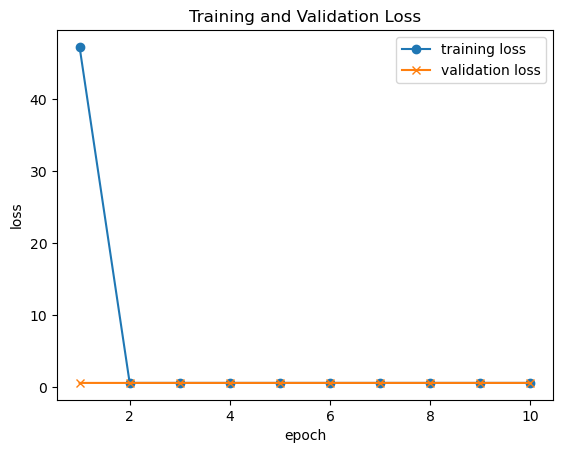

Training Accuracy: 0.6778
Validation Accuracy: 0.6780


In [31]:
# Set random seeds for reproducibility
tf.random.set_seed(1234)
np.random.seed(1234)

# Initialize the model
model_simple = tf.keras.Sequential()

# First convolutional block
model_simple.add(tf.keras.layers.Conv2D(
    filters=12,
    kernel_size=(4, 4),
    strides=(1, 1),
    padding='same',
    data_format='channels_last',
    activation='relu',
    name='conv_1'
))
model_simple.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Second convolutional block (added)
model_simple.add(tf.keras.layers.Conv2D(
    filters=24,  # Increased filters from 12 to 24
    kernel_size=(4, 4),
    strides=(1, 1),
    padding='same',
    activation='relu',
    name='conv_2'
))
model_simple.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Add dropout layer
model_simple.add(tf.keras.layers.Dropout(rate=0.3))

# Flattening layer
model_simple.add(tf.keras.layers.Flatten())

# Classification layer
model_simple.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Build and compile the model
model_simple.build(input_shape=(None, 128, 128, 3))
model_simple.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
                     loss=tf.keras.losses.BinaryCrossentropy(),
                     metrics=['accuracy'])

# Print model summary
model_simple.summary()

# Train the model
history = model_simple.fit(
    x=X_train_augmented,
    y=y_train_augmented,
    validation_data=(X_val, y_val),
    epochs=20,
    callbacks=[early_stopping]
)

# Plot loss curves
x_arr = np.arange(len(history.history['loss'])) + 1
plt.plot(x_arr, history.history['loss'], '-o', label='training loss')
plt.plot(x_arr, history.history['val_loss'], '-x', label='validation loss')
plt.title("Training and Validation Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

# Evaluate the model
train_loss, train_accuracy = model_simple.evaluate(X_train_augmented, y_train_augmented, verbose=0)
val_loss, val_accuracy = model_simple.evaluate(X_val, y_val, verbose=0)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_hidden (Dense)            │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,483,265 (32.36 MB)

 Trainable params: 8,482,817 (32.36 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/25
470/470 ━━━━━━━━━━━━━━━━━━━━ 82s 172ms/step - accuracy: 0.7553 - loss: 0.6970 - val_accuracy: 0.8085 - val_loss: 0.4561
Epoch 2/25
470/470 ━━━━━━━━━━━━━━━━━━━━ 80s 171ms/step - accuracy: 0.7986 - loss: 0.4682 - val_accuracy: 0.8292 - val_loss: 0.4433
Epoch 3/25
470/470 ━━━━━━━━━━━━━━━━━━━━ 77s 164ms/step - accuracy: 0.8092 - loss: 0.4489 - val_accuracy: 0.8292 - val_loss: 0.4179
Epoch 4/25
470/470 ━━━━━━━━━━━━━━━━━━━━ 77s 163ms/step - accuracy: 0.8227 - loss: 0.4279 - val_accuracy: 0.8328 - val_loss: 0.3882
Epoch 5/25
470/470 ━━━━━━━━━━━━━━━━━━━━ 77s 164ms/step - accuracy: 0.8347 - loss: 0.4046 - val_accuracy: 0.8400 - val_loss: 0.3700
Epoch 6/25
470/470 ━━━━━━━━━━━━━━━━━━━━ 78s 165ms/step - accuracy: 0.8411 - loss: 0.3786 - val_accuracy: 0.8408 - val_loss: 0.3667
Epoch 7/25
470/470 ━━━━━━━━━━━━━━━━━━━━ 78s 165ms/step - accuracy: 0.8511 - loss: 0.3576 - val_accuracy: 0.8536 - val_loss: 0.3589
Epoch 8/25
470/470 ━━━━━━━━━━━━━━━━━━━━ 76s 162ms/step - accuracy: 0.8652 - loss: 0

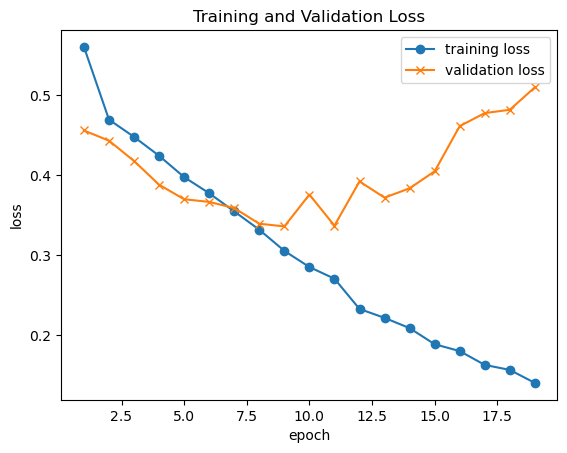

Training Accuracy: 0.8968
Validation Accuracy: 0.8655


In [32]:
# Set random seeds for reproducibility
tf.random.set_seed(1234)
np.random.seed(1234)

# Initialize the model
model_complex = tf.keras.Sequential()

# First convolutional block
model_complex.add(tf.keras.layers.Conv2D(
    filters=32,  # Increased filters to 32
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='same',
    activation='relu',
    name='conv_1'
))
model_complex.add(tf.keras.layers.BatchNormalization())  # Batch Normalization
model_complex.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Second convolutional block
model_complex.add(tf.keras.layers.Conv2D(
    filters=64,  # Increased filters to 64
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='same',
    activation='relu',
    name='conv_2'
))
model_complex.add(tf.keras.layers.BatchNormalization())  # Batch Normalization
model_complex.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Third convolutional block (added)
model_complex.add(tf.keras.layers.Conv2D(
    filters=128,  # Increased filters to 128
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='same',
    activation='relu',
    name='conv_3'
))
model_complex.add(tf.keras.layers.BatchNormalization())  # Batch Normalization
model_complex.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Dropout layer (reduced to 0.3)
model_complex.add(tf.keras.layers.Dropout(rate=0.3))

# Flatten layer
model_complex.add(tf.keras.layers.Flatten())

# Dense hidden layer
model_complex.add(tf.keras.layers.Dense(256, activation='relu', name='dense_hidden'))  # Increased units
model_complex.add(tf.keras.layers.Dropout(rate=0.4))  # Increased dropout

# Output layer
model_complex.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Build and compile the model
model_complex.build(input_shape=(None, 128, 128, 3))
model_complex.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Lower learning rate
                      loss=tf.keras.losses.BinaryCrossentropy(),
                      metrics=['accuracy'])

# Print the model summary
model_complex.summary()

# Train the model
history = model_complex.fit(
    x=X_train_augmented,
    y=y_train_augmented,
    validation_data=(X_val, y_val),
    epochs=25,
    callbacks=[early_stopping]
)

# Plot loss curves
x_arr = np.arange(len(history.history['loss'])) + 1
plt.plot(x_arr, history.history['loss'], '-o', label='training loss')
plt.plot(x_arr, history.history['val_loss'], '-x', label='validation loss')
plt.title("Training and Validation Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

# Evaluate the model
train_loss, train_accuracy = model_complex.evaluate(X_train_augmented, y_train_augmented, verbose=0)
val_loss, val_accuracy = model_complex.evaluate(X_val, y_val, verbose=0)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_hidden (Dense)            │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,483,265 (32.36 MB)

 Trainable params: 8,482,817 (32.36 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/15
470/470 ━━━━━━━━━━━━━━━━━━━━ 77s 162ms/step - accuracy: 0.7467 - loss: 1.1103 - val_accuracy: 0.7945 - val_loss: 0.5140
Epoch 2/15
470/470 ━━━━━━━━━━━━━━━━━━━━ 76s 163ms/step - accuracy: 0.7875 - loss: 0.4848 - val_accuracy: 0.8101 - val_loss: 0.4785
Epoch 3/15
470/470 ━━━━━━━━━━━━━━━━━━━━ 76s 163ms/step - accuracy: 0.8001 - loss: 0.4696 - val_accuracy: 0.8077 - val_loss: 0.4667
Epoch 4/15
470/470 ━━━━━━━━━━━━━━━━━━━━ 77s 164ms/step - accuracy: 0.8059 - loss: 0.4591 - val_accuracy: 0.8113 - val_loss: 0.4158
Epoch 5/15
470/470 ━━━━━━━━━━━━━━━━━━━━ 77s 163ms/step - accuracy: 0.8214 - loss: 0.4422 - val_accuracy: 0.8053 - val_loss: 0.4159
Epoch 6/15
470/470 ━━━━━━━━━━━━━━━━━━━━ 77s 163ms/step - accuracy: 0.8361 - loss: 0.4152 - val_accuracy: 0.7725 - val_loss: 0.5678
Epoch 7/15
470/470 ━━━━━━━━━━━━━━━━━━━━ 77s 163ms/step - accuracy: 0.8361 - loss: 0.4080 - val_accuracy: 0.8164 - val_loss: 0.4971
Epoch 8/15
470/470 ━━━━━━━━━━━━━━━━━━━━ 77s 163ms/step - accuracy: 0.8379 - loss: 0

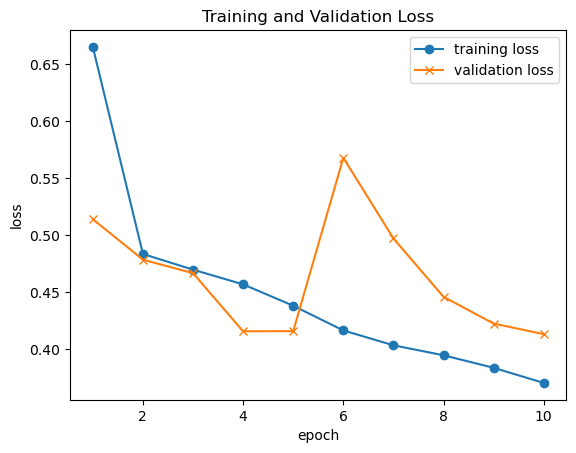

Training Accuracy: 0.7980
Validation Accuracy: 0.7945


In [33]:
# Set random seeds for reproducibility
tf.random.set_seed(1234)
np.random.seed(1234)

# Initialize the model
model_optimized = tf.keras.Sequential()

# First convolutional block
model_optimized.add(tf.keras.layers.Conv2D(
    filters=32,  # Kept increased filters to 32
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='same',
    activation='relu',
    name='conv_1'
))
model_optimized.add(tf.keras.layers.BatchNormalization())  # Batch Normalization
model_optimized.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Second convolutional block
model_optimized.add(tf.keras.layers.Conv2D(
    filters=64,  # Kept filters at 64
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='same',
    activation='relu',
    name='conv_2'
))
model_optimized.add(tf.keras.layers.BatchNormalization())  # Batch Normalization
model_optimized.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Third convolutional block
model_optimized.add(tf.keras.layers.Conv2D(
    filters=128,  # Kept filters at 128
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='same',
    activation='relu',
    name='conv_3'
))
model_optimized.add(tf.keras.layers.BatchNormalization())  # Batch Normalization
model_optimized.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Dropout layer (kept at 0.3)
model_optimized.add(tf.keras.layers.Dropout(rate=0.3))

# Flatten layer
model_optimized.add(tf.keras.layers.Flatten())

# Dense hidden layer
model_optimized.add(tf.keras.layers.Dense(256, activation='relu', name='dense_hidden'))  # Increased units
model_optimized.add(tf.keras.layers.Dropout(rate=0.4))  # Increased dropout

# Output layer
model_optimized.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Build and compile the model
model_optimized.build(input_shape=(None, 128, 128, 3))

# Increased learning rate to 0.0005 for faster convergence
model_optimized.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
                        loss=tf.keras.losses.BinaryCrossentropy(),
                        metrics=['accuracy'])

# Print the model summary
model_optimized.summary()

# Train the model with reduced epochs and early stopping
history = model_optimized.fit(
    x=X_train_augmented,
    y=y_train_augmented,
    validation_data=(X_val, y_val),
    epochs=15,  # Reduced epochs to speed up training
    callbacks=[early_stopping]  # Early stopping with patience
)

# Plot loss curves
x_arr = np.arange(len(history.history['loss'])) + 1
plt.plot(x_arr, history.history['loss'], '-o', label='training loss')
plt.plot(x_arr, history.history['val_loss'], '-x', label='validation loss')
plt.title("Training and Validation Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

# Evaluate the model
train_loss, train_accuracy = model_optimized.evaluate(X_train_augmented, y_train_augmented, verbose=0)
val_loss, val_accuracy = model_optimized.evaluate(X_val, y_val, verbose=0)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

---
### Step 7: Evaluate 

Use test data to evaluate the performance (accuracy) of your fine-tuned model on unseen data. Does your model generalize well?

In [ ]:
# test_loss, test_accuracy = model_fine_tuned.evaluate(test_dataset, verbose=0)

# # Print the test accuracy
# print(f"Test Loss: {test_loss:.4f}")
# print(f"Test Accuracy: {test_accuracy:.4f}")

# # Check if the model generalizes well
# if test_accuracy > val_accuracy - 0.05:  # Example: Allow a 5% drop from validation accuracy
#     print("The model generalizes well to unseen data.")
# else:
#     print("The model does not generalize well. Consider further fine-tuning or regularization.")

In [34]:
# Evaluate the model on the test dataset (X_test and y_test)
test_loss, test_accuracy = model_complex.evaluate(X_test, y_test, verbose=0)

# Print the test loss and test accuracy
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Check if the model generalizes well (test accuracy close to validation accuracy)
if test_accuracy > val_accuracy - 0.05:  # Allowing a 5% drop from validation accuracy
    print("The model generalizes well to unseen data.")
else:
    print("The model does not generalize well. Consider further fine-tuning or regularization.")

#


Test Loss: 0.3725
Test Accuracy: 0.8579
The model generalizes well to unseen data.


In [ ]:
# extracting y_test labels
y_test = np.concatenate([y.numpy() for _, y in test_dataset])

# predictions for test set 
y_test_pred_prob = model_fine_tuned.predict(test_dataset) 
y_test_pred = (y_test_pred_prob > 0.5).astype(int).flatten()

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['Healthy (hem)', 'Cancer (all)'])
disp.plot()
plt.xticks(rotation='vertical')
plt.title("Confusion Matrix")

# Recall and Percision
tn, fp, fn, tp = cm.ravel()

# Precision is the proportion of true positives out of both true positives and false positives.
precision = tp / (tp + fp)

# Recall is the proportion of true positives out of true positives + false negatives.
recall = tp / (tp + fn)

print(f"Precision Cancer (all): {precision:.4f}")
print(f"Recall Cancer (all): {recall:.4f}")